In [2]:
import os
import math
import csv
from typing import Tuple, Dict, Any
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


#**Architectures**


In [3]:
class SimpleMLP(nn.Module):
    """Small MLP for MNIST."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)


class SimpleCNN(nn.Module):
    """Basic CNN for MNIST."""
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 7x7
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


def get_model(arch_name: str) -> nn.Module:
    arch_name = arch_name.lower()
    if arch_name == "mlp":
        return SimpleMLP()
    elif arch_name == "cnn":
        return SimpleCNN()
    else:
        raise ValueError(f"Unknown architecture: {arch_name}")

#**Data**

In [4]:
def get_mnist_loaders(batch_size: int = 128, val_split: float = 0.1):
    transform = transforms.ToTensor()

    train_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    test_dataset = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )

    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(
        train_dataset, [train_size, val_size]
    )

    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

#**Helper utilities**


In [5]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def parameters_to_vector(model: nn.Module) -> torch.Tensor:
    return torch.nn.utils.parameters_to_vector(
        [p for p in model.parameters() if p.requires_grad]
    )


def vector_to_parameters(vec: torch.Tensor, model: nn.Module):
    torch.nn.utils.vector_to_parameters(vec, model.parameters())


def eval_on_loader(
    model: nn.Module, loader: DataLoader, device, criterion
) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples


def one_batch(loader: DataLoader, device):
    for x, y in loader:
        return x.to(device), y.to(device)
    raise RuntimeError("Empty loader")

# **Hessian / curvature utilities**

In [6]:
def hvp(
    model: nn.Module,
    criterion,
    x: torch.Tensor,
    y: torch.Tensor,
    v: torch.Tensor,
    device
) -> torch.Tensor:
    model.zero_grad()

    logits = model(x)
    loss = criterion(logits, y)

    params = [p for p in model.parameters() if p.requires_grad]
    grads = torch.autograd.grad(loss, params, create_graph=True)
    flat_grad = torch.cat([g.reshape(-1) for g in grads])

    scalar = torch.dot(flat_grad, v)
    Hv = torch.autograd.grad(scalar, params, retain_graph=False)
    flat_Hv = torch.cat([h.reshape(-1) for h in Hv])
    return flat_Hv


def estimate_lambda_max(
    model: nn.Module,
    criterion,
    curv_loader: DataLoader,
    device,
    num_steps: int = 20
) -> float:
    model.eval()
    x, y = one_batch(curv_loader, device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    v = torch.randn(num_params, device=device)
    v = v / v.norm()

    for _ in range(num_steps):
        Hv = hvp(model, criterion, x, y, v, device)
        Hv_norm = Hv.norm()
        if Hv_norm.item() == 0.0:
            return 0.0
        v = Hv / Hv_norm

    Hv = hvp(model, criterion, x, y, v, device)
    lambda_max = torch.dot(v, Hv).item()
    return lambda_max


def estimate_random_sharpness(
    model: nn.Module,
    criterion,
    curv_loader: DataLoader,
    device,
    epsilon: float = 1e-3,
    num_dirs: int = 20
) -> Tuple[float, float]:
    model.eval()
    x, y = one_batch(curv_loader, device)
    base_loss = criterion(model(x), y).item()

    theta = parameters_to_vector(model).detach()
    n_params = theta.numel()

    deltas = []
    for _ in range(num_dirs):
        u = torch.randn(n_params, device=device)
        u = u / u.norm()
        theta_pert = theta + epsilon * u
        vector_to_parameters(theta_pert, model)

        with torch.no_grad():
            loss_pert = criterion(model(x), y).item()
        deltas.append(loss_pert - base_loss)

    vector_to_parameters(theta, model)  # restore

    deltas_tensor = torch.tensor(deltas, device=device)
    sharp_max = deltas_tensor.max().item()
    sharp_mean = deltas_tensor.mean().item()
    return sharp_mean, sharp_max


def loss_2d_slice(
    model: nn.Module,
    criterion,
    val_loader: DataLoader,
    device,
    r: float = 5e-3,
    n_points: int = 21
):
    model.eval()
    base_theta = parameters_to_vector(model).detach()
    n_params = base_theta.numel()

    u = torch.randn(n_params, device=device)
    u = u / u.norm()
    v = torch.randn(n_params, device=device)
    v = v / v.norm()

    alphas = torch.linspace(-r, r, n_points, device=device)
    betas = torch.linspace(-r, r, n_points, device=device)
    loss_grid = torch.zeros(n_points, n_points, device=device)

    xs, ys = [], []
    for xb, yb in val_loader:
        xs.append(xb.to(device))
        ys.append(yb.to(device))

    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            theta = base_theta + a * u + b * v
            vector_to_parameters(theta, model)
            total_loss = 0.0
            total_samples = 0
            with torch.no_grad():
                for xb, yb in zip(xs, ys):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    total_loss += loss.item() * xb.size(0)
                    total_samples += xb.size(0)
            loss_grid[i, j] = total_loss / total_samples

    vector_to_parameters(base_theta, model)
    return alphas.cpu(), betas.cpu(), loss_grid.cpu()

#  **Main experiment runner**

In [7]:
def train_one_experiment(config: Dict[str, Any]):
    """
    config keys:
      - arch: "mlp" or "cnn"
      - batch_size
      - lr
      - num_epochs
      - name
      - log_root
    """
    arch = config["arch"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    num_epochs = config["num_epochs"]
    name = config["name"]
    log_root = config.get("log_root", "./logs_experiments")
    curv_interval = config.get("curv_interval", 1)

    exp_dir = os.path.join(log_root, name)
    os.makedirs(exp_dir, exist_ok=True)
    csv_path = os.path.join(exp_dir, "training_log.csv")

    device = get_device()
    print(f"Running experiment: {name} | arch={arch}, bs={batch_size}, lr={lr}")
    print("Using device:", device)

    train_loader, val_loader, test_loader = get_mnist_loaders(batch_size=batch_size)
    curv_loader = val_loader

    model = get_model(arch).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss",
            "train_acc",
            "val_loss",
            "val_acc",
            "test_loss",
            "test_acc",
            "lambda_max",
            "sharp_mean",
            "sharp_max",
        ])

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        val_loss, val_acc = eval_on_loader(model, val_loader, device, criterion)
        test_loss, test_acc = eval_on_loader(model, test_loader, device, criterion)

        lambda_max = float("nan")
        sharp_mean = float("nan")
        sharp_max = float("nan")

        if epoch % curv_interval == 0:
            print(f"[{name}] Estimating curvature at epoch {epoch}...")
            lambda_max = estimate_lambda_max(model, criterion, curv_loader, device, num_steps=15)
            sharp_mean, sharp_max = estimate_random_sharpness(
                model, criterion, curv_loader, device,
                epsilon=1e-3, num_dirs=10
            )

        with open(csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch,
                train_loss,
                train_acc,
                val_loss,
                val_acc,
                test_loss,
                test_acc,
                lambda_max,
                sharp_mean,
                sharp_max,
            ])

        print(
            f"[{name}] Epoch {epoch:02d} | "
            f"Train {train_loss:.4f}/{train_acc:.3f} | "
            f"Val {val_loss:.4f}/{val_acc:.3f} | "
            f"Test {test_acc:.3f} | "
            f"lambda_max {lambda_max:.4f} | sharp_max {sharp_max:.4f}"
        )

    # Final 2D slice
    print(f"[{name}] Computing 2D loss slice at final parameters...")
    alphas, betas, loss_grid = loss_2d_slice(
        model, criterion, val_loader, device, r=5e-3, n_points=21
    )
    torch.save(
        {"alphas": alphas, "betas": betas, "loss_grid": loss_grid},
        os.path.join(exp_dir, "loss_slice_2d.pt"),
    )
    print(f"[{name}] Done.")


if __name__ == "__main__":
    # Define experiments: MLP / CNN, high-noise vs low-noise SGD
    experiments = [
        {
            "name": "mlp_high_noise",
            "arch": "mlp",
            "batch_size": 64,
            "lr": 0.05,
            "num_epochs": 10,
            "log_root": "./logs_experiments",
            "curv_interval": 1,
        },
        {
            "name": "mlp_low_noise",
            "arch": "mlp",
            "batch_size": 2048,
            "lr": 0.01,
            "num_epochs": 10,
            "log_root": "./logs_experiments",
            "curv_interval": 1,
        },
        {
            "name": "cnn_high_noise",
            "arch": "cnn",
            "batch_size": 64,
            "lr": 0.05,
            "num_epochs": 10,
            "log_root": "./logs_experiments",
            "curv_interval": 1,
        },
        {
            "name": "cnn_low_noise",
            "arch": "cnn",
            "batch_size": 2048,
            "lr": 0.01,
            "num_epochs": 10,
            "log_root": "./logs_experiments",
            "curv_interval": 1,
        },
    ]

    for cfg in experiments:
        train_one_experiment(cfg)


Running experiment: mlp_high_noise | arch=mlp, bs=64, lr=0.05
Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 517kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.52MB/s]


[mlp_high_noise] Estimating curvature at epoch 1...
[mlp_high_noise] Epoch 01 | Train 0.2959/0.909 | Val 0.1237/0.961 | Test 0.965 | lambda_max 3.9259 | sharp_max 0.0000
[mlp_high_noise] Estimating curvature at epoch 2...
[mlp_high_noise] Epoch 02 | Train 0.0984/0.969 | Val 0.0923/0.973 | Test 0.973 | lambda_max 6.1285 | sharp_max 0.0000
[mlp_high_noise] Estimating curvature at epoch 3...
[mlp_high_noise] Epoch 03 | Train 0.0644/0.980 | Val 0.0730/0.977 | Test 0.978 | lambda_max 10.2849 | sharp_max 0.0000
[mlp_high_noise] Estimating curvature at epoch 4...
[mlp_high_noise] Epoch 04 | Train 0.0469/0.985 | Val 0.0717/0.979 | Test 0.979 | lambda_max 8.9661 | sharp_max 0.0000
[mlp_high_noise] Estimating curvature at epoch 5...
[mlp_high_noise] Epoch 05 | Train 0.0338/0.989 | Val 0.0875/0.974 | Test 0.978 | lambda_max 12.0240 | sharp_max 0.0000
[mlp_high_noise] Estimating curvature at epoch 6...
[mlp_high_noise] Epoch 06 | Train 0.0272/0.991 | Val 0.0752/0.978 | Test 0.979 | lambda_max 9.06

#**Plottings**

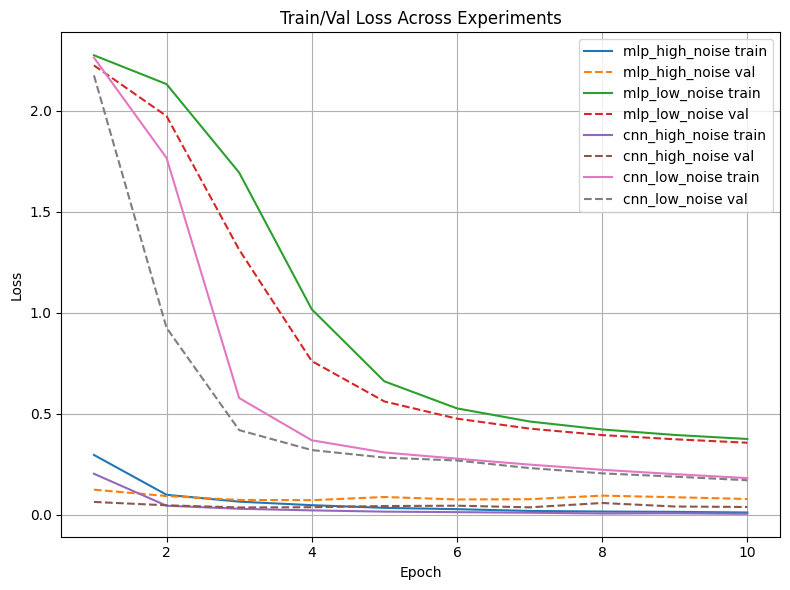

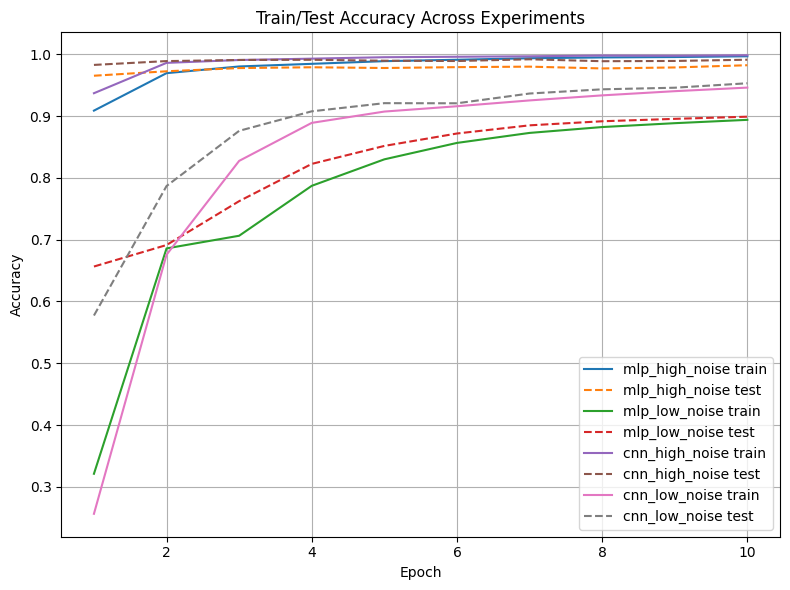

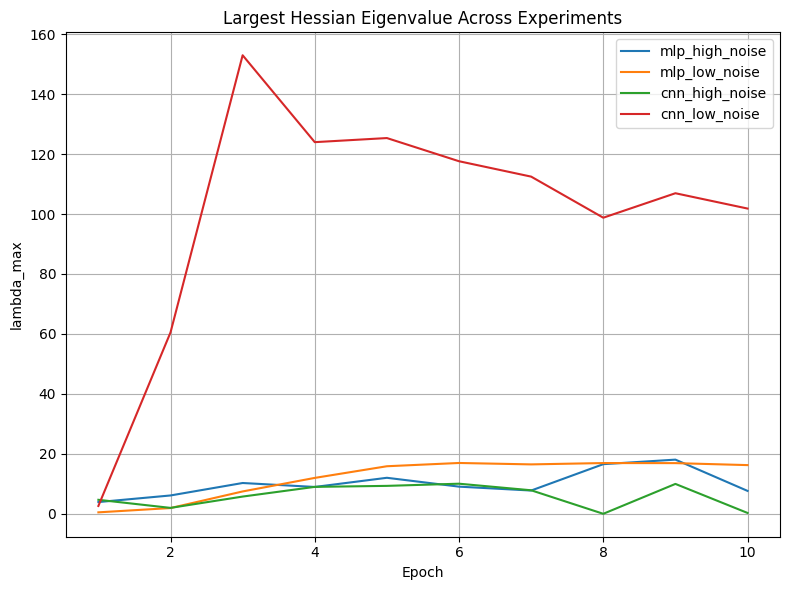

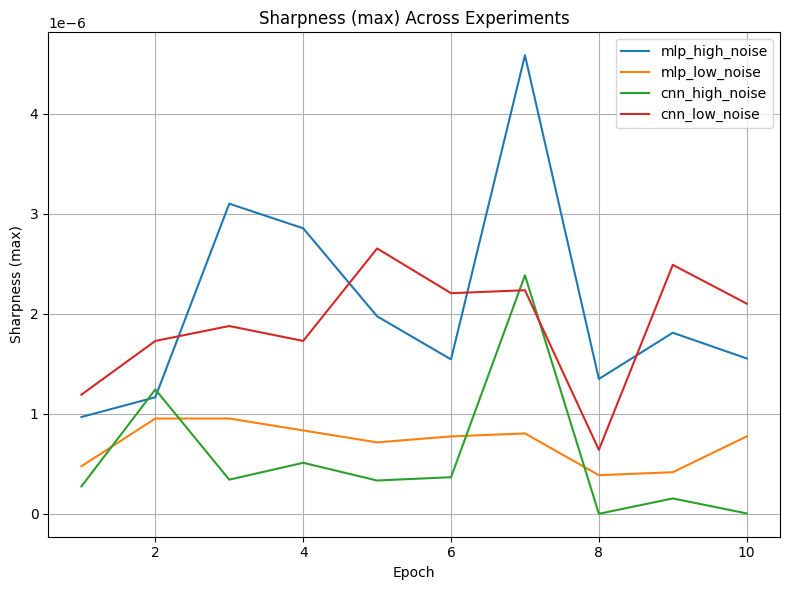

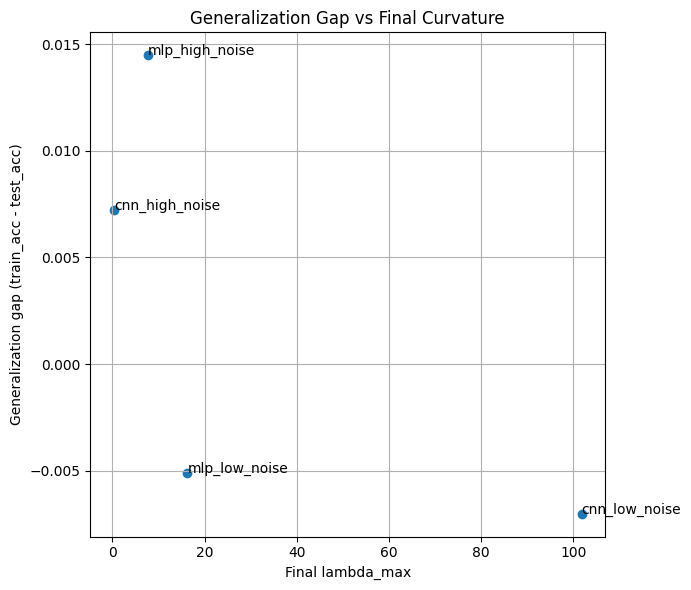

In [8]:
LOG_ROOT = "./logs_experiments"

EXPERIMENTS = [
    "mlp_high_noise",
    "mlp_low_noise",
    "cnn_high_noise",
    "cnn_low_noise",
]


def load_log(path):
    data = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "test_loss": [],
        "test_acc": [],
        "lambda_max": [],
        "sharp_mean": [],
        "sharp_max": [],
    }
    with open(path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            data["epoch"].append(int(row["epoch"]))
            data["train_loss"].append(float(row["train_loss"]))
            data["train_acc"].append(float(row["train_acc"]))
            data["val_loss"].append(float(row["val_loss"]))
            data["val_acc"].append(float(row["val_acc"]))
            data["test_loss"].append(float(row["test_loss"]))
            data["test_acc"].append(float(row["test_acc"]))
            data["lambda_max"].append(float(row["lambda_max"]))
            data["sharp_mean"].append(float(row["sharp_mean"]))
            data["sharp_max"].append(float(row["sharp_max"]))
    return data


def plot_loss_curves(logs):
    plt.figure(figsize=(8, 6))
    for name, log in logs.items():
        plt.plot(log["epoch"], log["train_loss"], label=f"{name} train")
        plt.plot(log["epoch"], log["val_loss"], linestyle="--", label=f"{name} val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Val Loss Across Experiments")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_acc_curves(logs):
    plt.figure(figsize=(8, 6))
    for name, log in logs.items():
        plt.plot(log["epoch"], log["train_acc"], label=f"{name} train")
        plt.plot(log["epoch"], log["test_acc"], linestyle="--", label=f"{name} test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train/Test Accuracy Across Experiments")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_lambda_max(logs):
    plt.figure(figsize=(8, 6))
    for name, log in logs.items():
        plt.plot(log["epoch"], log["lambda_max"], label=f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel("lambda_max")
    plt.title("Largest Hessian Eigenvalue Across Experiments")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_sharpness(logs):
    plt.figure(figsize=(8, 6))
    for name, log in logs.items():
        plt.plot(log["epoch"], log["sharp_max"], label=f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel("Sharpness (max)")
    plt.title("Sharpness (max) Across Experiments")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_generalization_vs_lambda(logs):
    # Use final epoch numbers
    labels = []
    gen_gaps = []
    lambdas = []

    for name, log in logs.items():
        train_acc = log["train_acc"][-1]
        test_acc = log["test_acc"][-1]
        gap = train_acc - test_acc
        lam = log["lambda_max"][-1]
        labels.append(name)
        gen_gaps.append(gap)
        lambdas.append(lam)

    plt.figure(figsize=(7, 6))
    plt.scatter(lambdas, gen_gaps)
    for i, lab in enumerate(labels):
        plt.annotate(lab, (lambdas[i], gen_gaps[i]))

    plt.xlabel("Final lambda_max")
    plt.ylabel("Generalization gap (train_acc - test_acc)")
    plt.title("Generalization Gap vs Final Curvature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    logs = {}
    for exp in EXPERIMENTS:
        csv_path = os.path.join(LOG_ROOT, exp, "training_log.csv")
        if os.path.exists(csv_path):
            logs[exp] = load_log(csv_path)
        else:
            print(f"Warning: log not found for {exp}")

    if not logs:
        raise RuntimeError("No logs loaded. Run experiments first.")

    plot_loss_curves(logs)
    plot_acc_curves(logs)
    plot_lambda_max(logs)
    plot_sharpness(logs)
    plot_generalization_vs_lambda(logs)


GIT

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!git config --global user.email "hs3836812@gmail.com"
!git config --global user.name "Harsh Soni"

In [12]:
!git clone https://github.com/Harshsoni38/Fourkites_Problem_3.git

Cloning into 'Fourkites_Problem_3'...


In [13]:
!cp -r data REPO/
!cp -r logs_experiments REPO/
!cp -r sample_data REPO/
!cp FourKites.ipynb REPO/

cp: cannot stat 'data': No such file or directory
cp: cannot stat 'FourKites.ipynb': No such file or directory


In [14]:
%cd REPO/
!git add .
!git commit -m "Initial commit"
!git push https://github.com/Harshsoni38/Fourkites_Problem_3.git

/content/REPO/REPO
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [16]:
%cd /content/
!ls

/content
data  Fourkites_Problem_3  logs_experiments  REPO  sample_data


In [1]:
!ls *.ipynb


ls: cannot access '*.ipynb': No such file or directory
